In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json

import sys

sys.path.append("../")

##################################################################
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"
##################################################################

import logging
from src.utils import logging_utils
from src.utils import env_utils

logger = logging.getLogger(__name__)

logging.basicConfig(
    level=logging.DEBUG,
    format=logging_utils.DEFAULT_FORMAT,
    datefmt=logging_utils.DEFAULT_DATEFMT,
    stream=sys.stdout,
)

import torch
import transformers

logger.info(f"{torch.__version__=}, {torch.version.cuda=}")
logger.info(
    f"{torch.cuda.is_available()=}, {torch.cuda.device_count()=}, {torch.cuda.get_device_name()=}"
)
logger.info(f"{transformers.__version__=}")

2025-08-29 08:26:47 __main__ INFO     torch.__version__='2.7.0+cu126', torch.version.cuda='12.6'
2025-08-29 08:26:48 __main__ INFO     torch.cuda.is_available()=True, torch.cuda.device_count()=8, torch.cuda.get_device_name()='NVIDIA A100 80GB PCIe'
2025-08-29 08:26:48 __main__ INFO     transformers.__version__='4.55.3'


In [3]:
from src.utils.training_utils import get_device_map

# model_key = "meta-llama/Llama-3.2-3B"
# model_key = "meta-llama/Llama-3.1-8B"
# model_key = "meta-llama/Llama-3.1-70B-Instruct"
# model_key = "meta-llama/Llama-3.3-70B-Instruct"
# model_key = "meta-llama/Llama-3.1-405B-Instruct"

# model_key = "google/gemma-2-9b-it"
# model_key = "google/gemma-3-12b-it"
model_key = "google/gemma-2-27b-it"

# model_key = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

# model_key = "allenai/OLMo-2-1124-7B-Instruct"
# model_key = "allenai/OLMo-7B-0424-hf"

# model_key = "Qwen/Qwen2-7B"
# model_key = "Qwen/Qwen2.5-14B-Instruct"
# model_key = "Qwen/Qwen2.5-32B-Instruct"
# model_key = "Qwen/Qwen2.5-72B-Instruct"

# model_key = "Qwen/Qwen3-1.7B"
# model_key = "Qwen/Qwen3-4B"
# model_key = "Qwen/Qwen3-8B"
# model_key = "Qwen/Qwen3-14B"
# model_key = "Qwen/Qwen3-32B"

# device_map = get_device_map(model_key, 30, n_gpus=8)
# device_map

2025-08-29 08:26:51 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-29 08:26:51 git.cmd DEBUG    Popen(['git', 'version'], cwd=/disk/u/arnab/Codes/Projects/retrieval/notebooks, stdin=None, shell=False, universal_newlines=False)
2025-08-29 08:26:51 wandb.docker.auth DEBUG    Trying paths: ['/disk/u/arnab/.docker/config.json', '/disk/u/arnab/.dockercfg']
2025-08-29 08:26:51 wandb.docker.auth DEBUG    No config file found


In [4]:
# from nnsight import LanguageModel

# lm = LanguageModel(
#     model_key,
#     device_map="auto",
#     dispatch=True,
# )

In [5]:
from src.models import ModelandTokenizer

# from transformers import BitsAndBytesConfig

mt = ModelandTokenizer(
    model_key=model_key,
    torch_dtype=torch.bfloat16,
    # device_map=device_map,
    device_map="auto",
    # quantization_config = BitsAndBytesConfig(
    #     # load_in_4bit=True
    #     load_in_8bit=True
    # )
    attn_implementation="eager",
)

2025-08-29 08:26:53 src.models WARNING  google/gemma-2-27b-it not found in /disk/u/arnab/Codes/Models
If not found in cache, model will be downloaded from HuggingFace to cache directory
2025-08-29 08:26:53 urllib3.connectionpool DEBUG    Starting new HTTPS connection (1): huggingface.co:443


2025-08-29 08:26:53 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /google/gemma-2-27b-it/resolve/main/config.json HTTP/1.1" 200 0
2025-08-29 08:26:53 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /google/gemma-2-27b-it/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
2025-08-29 08:26:53 urllib3.connectionpool DEBUG    https://huggingface.co:443 "GET /api/models/google/gemma-2-27b-it/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64


Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]

2025-08-29 08:27:14 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /google/gemma-2-27b-it/resolve/main/generation_config.json HTTP/1.1" 200 0
2025-08-29 08:27:14 urllib3.connectionpool DEBUG    https://huggingface.co:443 "HEAD /google/gemma-2-27b-it/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
2025-08-29 08:27:14 src.models INFO     loaded model <google/gemma-2-27b-it> | size: 51931.626 MB | dtype: torch.bfloat16 | device: cuda:0


In [6]:
from src.selection.data import SelectOneTask, SelectOrderTask

#################################################################################
# TASK_CLS = SelectOrderTask
# prompt_template_idx = 1
TASK_CLS = SelectOneTask
prompt_template_idx = 3
N_DISTRACTORS = 5
OPTION_STYLE = "single_line"
#################################################################################

select_task = TASK_CLS.load(
    path=os.path.join(
        env_utils.DEFAULT_DATA_DIR, 
        "selection", 
        # "profession.json"
        # "nationality.json"
        "objects.json"
    )
)

print(select_task)

SelectOneTask: (different objects)
Categories: fruit(15), vehicle(15), furniture(15), animal(15), music instrument(15), clothing(15), electronics(15), sport equipment(15), kitchen appliance(15), vegetable(14), building(15), office supply(15), bathroom item(15), flower(15), tree(15), jewelry(15)



In [7]:
import copy
import random
from src.selection.utils import KeyedSet, get_first_token_id, verify_correct_option
from src.selection.data import SelectionSample
from src.functional import predict_next_token
from src.tokens import prepare_input

######################################################################
N_DISTRACTORS = 5
WINDOW_SPEC = {
    mt.layer_name_format: 1,
    mt.mlp_module_name_format: 9,
    mt.attn_module_name_format: 9,
}
module_name_format = mt.layer_name_format
# module_name_format = mt.mlp_module_name_format
# module_name_format = mt.attn_module_name_format

######################################################################


@torch.inference_mode()
def get_counterfactual_samples_within_task(
    task: SelectOneTask | SelectOrderTask,
    mt: ModelandTokenizer,
    patch_category: str | None = None,
    clean_category: str | None = None,
    shuffle_clean_options: bool = False,
    prompt_template_idx=3,
    option_style="single_line",
    filter_by_lm_prediction: bool = True,
    distinct_options: bool = False,
    n_distractors: int = 5,
    patch_n_distractors: int | None = None,
    clean_n_distractors: int | None = None,
):
    categories = list(task.category_wise_examples.keys())
    if patch_category is None:
        patch_category = random.choice(categories)

    if patch_n_distractors is None:
        patch_n_distractors = n_distractors

    patch_subj, patch_obj = random.sample(
        task.category_wise_examples[patch_category], 2
    )
    # logger.info(
    #     f"Patch category: {patch_category}, subject: {patch_subj}, object: {patch_obj}"
    # )

    if clean_category is None:
        clean_category = random.choice(list(set(categories) - {patch_category}))

    clean_options = task.category_wise_examples[clean_category]
    random.shuffle(clean_options)

    clean_subj, clean_obj = random.sample(
        (
            KeyedSet(clean_options, mt.tokenizer) - KeyedSet([patch_obj], mt.tokenizer)
        ).values,
        2,
    )
    # logger.info(
    #     f"Clean category: {clean_category}, subject: {clean_subj}, object: {clean_obj}"
    # )

    if distinct_options is False:
        patch_type_obj = patch_obj
        clean_type_obj = clean_obj
    else:
        patch_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[patch_category], mt.tokenizer)
                - KeyedSet([patch_obj], mt.tokenizer)
            ).values
        )
        clean_type_obj = random.choice(
            (
                KeyedSet(task.category_wise_examples[clean_category], mt.tokenizer)
                - KeyedSet([clean_obj], mt.tokenizer)
            ).values
        )

    patch_must_have_options = [patch_obj, clean_type_obj]
    clean_must_have_options = [clean_obj, patch_type_obj]

    # logger.info(f"{patch_must_have_options=}")
    # logger.info(f"{clean_must_have_options=}")
    # logger.info(f"{clean_type_obj=}")
    # logger.info(f"{patch_type_obj=}")

    patch_distractors = []
    other_categories = random.sample(
        list(set(categories) - {patch_category, clean_category}),
        k=patch_n_distractors - (len(patch_must_have_options)) + 1,
    )

    for other_category in other_categories:
        other_examples = task.category_wise_examples[other_category]
        random.shuffle(other_examples)
        other_examples = KeyedSet(other_examples, mt.tokenizer)
        patch_distractors.append(
            random.choice(
                (
                    other_examples
                    - KeyedSet(
                        patch_must_have_options + patch_distractors,
                        tokenizer=mt.tokenizer,
                    )
                ).values
            )
        )

    patch_options = patch_must_have_options + patch_distractors
    random.shuffle(patch_options)
    patch_obj_idx = patch_options.index(patch_obj)
    # logger.info(f"{patch_obj_idx=} | {patch_options}")

    if distinct_options is not True:
        if clean_n_distractors is not None:
            logger.warning(
                f"Passed {clean_n_distractors=}. But distinct_options is False, so clean options will be same as patch options."
            )
        clean_options = copy.deepcopy(patch_options)
        if shuffle_clean_options:
            # Useful for the pointer experiments
            while (
                clean_options.index(clean_obj) == patch_obj_idx
                or clean_options.index(patch_type_obj) == patch_obj_idx
            ):
                random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    else:
        if clean_n_distractors is None:
            clean_n_distractors = n_distractors
        other_categories = random.sample(
            list(set(categories) - {patch_category, clean_category}),
            k=clean_n_distractors - (len(clean_must_have_options)) + 1,
        )
        clean_distractors = []
        for other_category in other_categories:
            other_examples = task.category_wise_examples[other_category]
            random.shuffle(other_examples)
            other_examples = KeyedSet(other_examples, mt.tokenizer)
            clean_distractors.append(
                random.choice(
                    (
                        other_examples
                        - KeyedSet(
                            clean_must_have_options + clean_distractors,
                            tokenizer=mt.tokenizer,
                        )
                    ).values
                )
            )
        clean_options = clean_must_have_options + clean_distractors
        random.shuffle(clean_options)
        while (
            clean_options.index(clean_obj) == patch_obj_idx
            or clean_options.index(patch_type_obj) == patch_obj_idx
        ):
            random.shuffle(clean_options)
        clean_obj_idx = clean_options.index(clean_obj)

    logger.info(f"{clean_obj_idx=} | {clean_options}")

    kwargs = dict(
        prompt_template=task.prompt_templates[prompt_template_idx],
        default_option_style=option_style,
    )
    print(f"{type(task)=}")
    if isinstance(task, SelectOrderTask):
        patch_metadata = {
            "track_type_obj_idx": clean_obj_idx,
            "track_type_obj": patch_options[clean_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                patch_options[clean_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_type_obj_idx": patch_obj_idx,
            "track_type_obj": clean_options[patch_obj_idx],
            "track_type_obj_token_id": get_first_token_id(
                clean_options[patch_obj_idx], mt.tokenizer, prefix=" "
            ),
        }
    elif isinstance(task, SelectOneTask):
        patch_metadata = {
            "track_category": clean_category,
            "track_type_obj": clean_type_obj,
            "track_type_obj_idx": patch_options.index(clean_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                clean_type_obj, mt.tokenizer, prefix=" "
            ),
        }
        clean_metadata = {
            "track_category": patch_category,
            "track_type_obj": patch_type_obj,
            "track_type_obj_idx": clean_options.index(patch_type_obj),
            "track_type_obj_token_id": get_first_token_id(
                patch_type_obj, mt.tokenizer, prefix=" "
            ),
        }
    else:
        raise NotImplementedError(f"Unsupported task type: {type(task)}")

    patch_sample = SelectionSample(
        subj=patch_subj,
        obj=patch_obj,
        answer=patch_obj,
        obj_idx=patch_obj_idx,
        ans_token_id=get_first_token_id(patch_obj, mt.tokenizer, prefix=" "),
        options=patch_options,
        category=patch_category,
        metadata=patch_metadata,
        **kwargs,
    )
    clean_sample = SelectionSample(
        subj=clean_subj,
        obj=clean_obj,
        answer=clean_obj,
        obj_idx=clean_obj_idx,
        ans_token_id=get_first_token_id(clean_obj, mt.tokenizer, prefix=" "),
        options=clean_options,
        category=clean_category,
        metadata=clean_metadata,
        **kwargs,
    )

    if "qwen" in mt.name.lower():
        # for attention sink
        patch_sample.prompt_template = "# " + patch_sample.prompt_template
        clean_sample.prompt_template = "# " + clean_sample.prompt_template

    if filter_by_lm_prediction:
        test_samples = [patch_sample, clean_sample]
        if distinct_options is True:
            clean_sample_2 = copy.deepcopy(patch_sample)
            clean_sample_2.options = clean_options
            clean_sample_2.obj = clean_sample.metadata["track_type_obj"]
            clean_sample_2.obj_idx = clean_sample.metadata["track_type_obj_idx"]
            clean_sample_2.ans_token_id = clean_sample.metadata[
                "track_type_obj_token_id"
            ]
            test_samples.append(clean_sample_2)

        for sample in test_samples:
            tokenized = prepare_input(tokenizer=mt, prompts=sample.prompt())
            is_correct, predictions, track_options = verify_correct_option(
                mt=mt, target=sample.obj, options=sample.options, input=tokenized
            )
            # sample.metadata["tokenized"] = tokenized.data
            logger.info(sample.prompt())
            logger.info(
                f"{sample.subj} | {sample.category} -> {sample.obj} | pred={[str(p) for p in predictions]}"
            )
            if not is_correct:
                logger.error(
                    f'Prediction mismatch: {track_options[list(track_options.keys())[0]]}["{mt.tokenizer.decode(predictions[0].token_id)}"] != {sample.ans_token_id}["{mt.tokenizer.decode(sample.ans_token_id)}"]'
                )
                return get_counterfactual_samples_within_task(
                    mt=mt,
                    task=task,
                    patch_category=patch_category,
                    clean_category=clean_category,
                    shuffle_clean_options=shuffle_clean_options,
                    prompt_template_idx=prompt_template_idx,
                    option_style=option_style,
                    filter_by_lm_prediction=filter_by_lm_prediction,
                    distinct_options=distinct_options,
                    n_distractors=n_distractors,
                )
            sample.prediction = predictions

    return patch_sample, clean_sample

In [8]:
patch_sample, clean_sample = get_counterfactual_samples_within_task(
    # patch_category="politician",
    # clean_category="actor",
    mt=mt,
    task=select_task,
    patch_category="fruit",
    clean_category="vehicle",
    filter_by_lm_prediction=True,
    prompt_template_idx=prompt_template_idx,
    option_style=OPTION_STYLE,
    distinct_options=True,
    patch_n_distractors=5,
    clean_n_distractors=5
)

# patch_sample.default_option_style = "single_line"
# clean_sample.default_option_style = "numbered"

print(patch_sample.prompt(), ">>", patch_sample.obj)
print(clean_sample.prompt(), ">>", clean_sample.obj)

2025-08-29 08:27:19 __main__ INFO     clean_obj_idx=3 | ['Blueberry', 'Smartwatch', 'Trumpet', 'Bus', 'Bookshelf', 'Surfboard']


type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-29 08:27:20 __main__ INFO     Options: Daisy, Pear, Coffee table, Eagle, Ambulance, Mushroom.
Which among these objects mentioned above is a fruit?
Answer:
2025-08-29 08:27:20 __main__ INFO     Watermelon | fruit -> Pear | pred=['" **"[5231] (p=0.395, logit=20.125)', '" Pear"[19189] (p=0.395, logit=20.125)', '" Daisy"[63255] (p=0.088, logit=18.625)', '"\n\n"[109] (p=0.061, logit=18.250)', '"  "[139] (p=0.029, logit=17.500)']
2025-08-29 08:27:20 __main__ INFO     Options: Blueberry, Smartwatch, Trumpet, Bus, Bookshelf, Surfboard.
Which among these objects mentioned above is a vehicle?
Answer:
2025-08-29 08:27:20 __main__ INFO     Helicopter | vehicle -> Bus | pred=['" Bus"[13632] (p=0.652, logit=20.375)', '" **"[5231] (p=0.309, logit=19.625)', '"\n\n"[109] (p=0.015, logit=16.625)', '"  "[139] (p=0.011, logit=16.250)', '"\n"[108] (p=0.004, logit=15.188)']
2025-08-29 08:27:20 __main__ INFO     Options: Blueberry, Smartwatch, Tr

In [9]:
clean_tokenized = prepare_input(tokenizer=mt, prompts=clean_sample.prompt())
print(mt.tokenizer.decode(clean_tokenized.input_ids[0], skip_special_tokens=False))

<bos>Options: Blueberry, Smartwatch, Trumpet, Bus, Bookshelf, Surfboard.
Which among these objects mentioned above is a vehicle?
Answer:


In [11]:
from src.tokens import prepare_input
from src.selection.utils import get_first_token_id
from src.functional import interpret_logits, PatchSpec
from itertools import product
from src.utils.typing import TokenizerOutput, ArrayLike
from typing import Optional, Union
from src.functional import get_module_nnsight, untuple, get_hs, predict_next_token

def layer_wise_patching(
    mt: ModelandTokenizer,
    patch_sample: SelectionSample,
    clean_sample: SelectionSample,
    token_indices: list[int] = [-3, -2, -1],
):
    patch_tokenized = prepare_input(
        tokenizer=mt.tokenizer, prompts=patch_sample.prompt()
    )
    clean_tokenized = prepare_input(
        tokenizer=mt.tokenizer, prompts=clean_sample.prompt()
    )

    random_idx = random.choice(
        list(
            set(list(range(len(clean_sample.options))))
            - {
                patch_sample.obj_idx,
                clean_sample.obj_idx,
                clean_sample.metadata["track_type_obj_idx"],
            }
        )
    )

    track_tokens = {
        "predicate_target": clean_sample.metadata["track_type_obj_token_id"],
        "clean_ans": get_first_token_id(clean_sample.obj, mt.tokenizer, prefix=" "),
        "patch_ans": get_first_token_id(patch_sample.obj, mt.tokenizer, prefix=" "),
        "patch_position": get_first_token_id(
            clean_sample.options[patch_sample.obj_idx], mt.tokenizer, prefix=" "
        ),
        "random_distractor": get_first_token_id(
            clean_sample.options[random_idx], mt.tokenizer, prefix=" "
        ),
    }

    ret = {"track_tokens": track_tokens}

    logit_location = (mt.lm_head_name, -1)
    patch_locations = list(product(mt.layer_names, token_indices))
    # patch_locations = []
    print(patch_locations)

    patch_hs = get_hs(
        mt=mt,
        input=patch_tokenized,
        locations=patch_locations + [logit_location],
        return_dict=True,
    )
    patch_logits = patch_hs[logit_location]
    patch_pred, patch_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=patch_logits,
        interested_tokens=track_tokens.values(),
    )
    logger.debug(f"patch_pred={[str(pred) for pred in patch_pred]}")
    logger.debug(f"patch_track={patch_track}")
    ret["patch_pred"] = patch_pred
    ret["patch_track"] = patch_track

    clean_hs = get_hs(
        mt=mt,
        input=clean_tokenized,
        locations=patch_locations + [logit_location],
        return_dict=True,
    )
    clean_logits = clean_hs[logit_location]
    clean_pred, clean_track = interpret_logits(
        tokenizer=mt.tokenizer,
        logits=clean_logits,
        interested_tokens=track_tokens.values(),
    )
    logger.debug(f"clean_pred={[str(pred) for pred in clean_pred]}")
    logger.debug(f"clean_track={clean_track}")
    ret["clean_pred"] = clean_pred
    ret["clean_track"] = clean_track

    layer_wise_patching_results = {}
    for layer in mt.layer_names:
        patch_spec = []
        for token_idx in token_indices:
            patch_spec.append(
                PatchSpec(
                    location=(layer, token_idx), patch=patch_hs[(layer, token_idx)]
                )
            )

        # int_pred, int_track = predict_next_token(
        #     mt=mt,
        #     inputs=clean_tokenized,
        #     token_of_interest=track_tokens.values(),
        #     patches=patch_spec
        # )
        int_hs = get_hs(
            mt=mt,
            input=clean_tokenized,
            locations=[logit_location],
            patches=patch_spec,
            return_dict=True,
        )
        int_logits = int_hs[logit_location]
        int_pred, int_track = interpret_logits(
            tokenizer=mt.tokenizer,
            logits=int_logits,
            interested_tokens=track_tokens.values(),
        )

        logger.debug(f"Layer {layer}: int_pred={[str(pred) for pred in int_pred]}")
        layer_wise_patching_results[layer] = {
            "int_pred": int_pred,
            "int_track": int_track,
        }

    ret["layer_wise_patching_results"] = layer_wise_patching_results
    return ret


patching_result = layer_wise_patching(
    mt=mt,
    patch_sample=patch_sample,
    clean_sample=clean_sample,
    token_indices=[-3, -2, -1],
)

[('model.layers.0', -3), ('model.layers.0', -2), ('model.layers.0', -1), ('model.layers.1', -3), ('model.layers.1', -2), ('model.layers.1', -1), ('model.layers.2', -3), ('model.layers.2', -2), ('model.layers.2', -1), ('model.layers.3', -3), ('model.layers.3', -2), ('model.layers.3', -1), ('model.layers.4', -3), ('model.layers.4', -2), ('model.layers.4', -1), ('model.layers.5', -3), ('model.layers.5', -2), ('model.layers.5', -1), ('model.layers.6', -3), ('model.layers.6', -2), ('model.layers.6', -1), ('model.layers.7', -3), ('model.layers.7', -2), ('model.layers.7', -1), ('model.layers.8', -3), ('model.layers.8', -2), ('model.layers.8', -1), ('model.layers.9', -3), ('model.layers.9', -2), ('model.layers.9', -1), ('model.layers.10', -3), ('model.layers.10', -2), ('model.layers.10', -1), ('model.layers.11', -3), ('model.layers.11', -2), ('model.layers.11', -1), ('model.layers.12', -3), ('model.layers.12', -2), ('model.layers.12', -1), ('model.layers.13', -3), ('model.layers.13', -2), ('mo

In [11]:
from src.functional import free_gpu_cache
free_gpu_cache()
validation_set = []
validation_limit = 64

while len(validation_set) < validation_limit:
    print(f"sample {len(validation_set)+1} / {validation_limit}")
    patch, clean = get_counterfactual_samples_within_task(
        mt=mt,
        task=select_task,
        filter_by_lm_prediction=True,
        prompt_template_idx=prompt_template_idx,
        option_style=OPTION_STYLE,
        distinct_options=True,
        # n_distractors=N_DISTRACTORS,
        patch_n_distractors=N_DISTRACTORS,
        clean_n_distractors=N_DISTRACTORS
    )
    validation_set.append((clean, patch))

len(validation_set)

sample 1 / 64
2025-08-29 01:54:29 __main__ INFO     clean_obj_idx=2 | ['Bracelet', 'Mirror', 'Cow', 'Bamboo', 'Tulip', 'Mosque']
type(task)=<class 'src.selection.data.SelectOneTask'>
2025-08-29 01:54:29 __main__ INFO     Options: Toothbrush, Elephant, Coffee table, Camera, School, Orange.
Which among these objects mentioned above is a bathroom item?
Answer:
2025-08-29 01:54:29 __main__ INFO     Hairdryer | bathroom item -> Toothbrush | pred=['" Tooth"[69200] (p=0.934, logit=21.500)', '" **"[5231] (p=0.060, logit=18.750)', '"  "[139] (p=0.002, logit=15.125)', '"\n\n"[109] (p=0.001, logit=14.875)', '"Tooth"[109555] (p=0.001, logit=14.750)']
2025-08-29 01:54:30 __main__ INFO     Options: Bracelet, Mirror, Cow, Bamboo, Tulip, Mosque.
Which among these objects mentioned above is a animal?
Answer:
2025-08-29 01:54:30 __main__ INFO     Sheep | animal -> Cow | pred=['" Cow"[20845] (p=0.965, logit=22.625)', '" **"[5231] (p=0.033, logit=19.250)', '"Cow"[44111] (p=0.000, logit=15.062)', '"  "[139

64

In [12]:
results = []
for clean, patch in validation_set:
    result = layer_wise_patching(
        mt=mt,
        patch_sample=patch,
        clean_sample=clean,
        token_indices=[-3, -2, -1]
    )
    results.append(result)

[('model.layers.0', -3), ('model.layers.0', -2), ('model.layers.0', -1), ('model.layers.1', -3), ('model.layers.1', -2), ('model.layers.1', -1), ('model.layers.2', -3), ('model.layers.2', -2), ('model.layers.2', -1), ('model.layers.3', -3), ('model.layers.3', -2), ('model.layers.3', -1), ('model.layers.4', -3), ('model.layers.4', -2), ('model.layers.4', -1), ('model.layers.5', -3), ('model.layers.5', -2), ('model.layers.5', -1), ('model.layers.6', -3), ('model.layers.6', -2), ('model.layers.6', -1), ('model.layers.7', -3), ('model.layers.7', -2), ('model.layers.7', -1), ('model.layers.8', -3), ('model.layers.8', -2), ('model.layers.8', -1), ('model.layers.9', -3), ('model.layers.9', -2), ('model.layers.9', -1), ('model.layers.10', -3), ('model.layers.10', -2), ('model.layers.10', -1), ('model.layers.11', -3), ('model.layers.11', -2), ('model.layers.11', -1), ('model.layers.12', -3), ('model.layers.12', -2), ('model.layers.12', -1), ('model.layers.13', -3), ('model.layers.13', -2), ('mo

In [12]:
results = [patching_result]

scores = {token_type: [] for token_type in results[0]["track_tokens"].keys()}
for result in results:
    clean_track = result["clean_track"]
    patch_track = result["patch_track"]

    for token_type in scores.keys():
        layerwise_scores = []
        token_id = result["track_tokens"][token_type]
        for layer_idx in range(mt.n_layer):
            score = result["layer_wise_patching_results"][mt.layer_names[layer_idx]]["int_track"][token_id][1].logit
            layerwise_scores.append(score)
        scores[token_type].append(layerwise_scores)

2025-08-29 08:29:04 matplotlib DEBUG    matplotlib data path: /disk/u/arnab/miniconda3/envs/connection/lib/python3.11/site-packages/matplotlib/mpl-data
2025-08-29 08:29:04 matplotlib DEBUG    CONFIGDIR=/disk/u/arnab/.config/matplotlib
2025-08-29 08:29:04 matplotlib DEBUG    interactive is False
2025-08-29 08:29:04 matplotlib DEBUG    platform is linux
2025-08-29 08:29:05 matplotlib DEBUG    CACHEDIR=/disk/u/arnab/.cache/matplotlib
2025-08-29 08:29:05 matplotlib.font_manager DEBUG    Using fontManager instance from /disk/u/arnab/.cache/matplotlib/fontlist-v390.json
2025-08-29 08:29:05 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-29 08:29:05 matplotlib.pyplot DEBUG    Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-08-29 08:29:05 matplotlib.font_manager DEBUG    findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-08-29 08:29:05 matplotlib.font

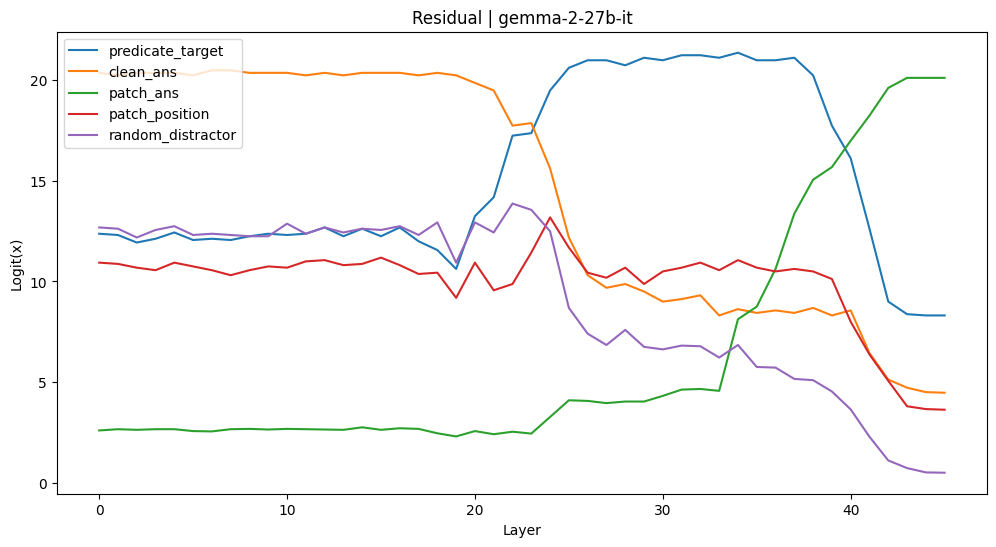

In [13]:
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
for token_type, layerwise_scores_list in scores.items():
    # Compute mean and std deviation across results for each layer
    mean_scores = np.mean(layerwise_scores_list, axis=0)
    sterr_scores = np.std(layerwise_scores_list, axis=0) / np.sqrt(len(layerwise_scores_list))

    plt.plot(mean_scores, label=f"{token_type}")
    plt.fill_between(range(len(mean_scores)), mean_scores - sterr_scores, mean_scores + sterr_scores, alpha=0.2)

plt.xlabel("Layer")
plt.ylabel("Logit(x)")
plt.title(f"Residual | {mt.name.split('/')[-1]}")
plt.legend()
plt.show()